# Example ODE

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on a problem involving a viscoelastic system.

We start by importing the required libraries and setting the plotting style:

In [80]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
plt.style.use('ggplot')
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.training import train_deepmod, train_mse
import VE_datagen as VE_datagen

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we prepare the dataset.

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

Specify the functional form of the input

In [81]:
# sinc
omega = 1
Amp = 1
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: Amp*torch.sin(omega*t)/(omega*t)

input_type = 'Stress'
func_desc = 'Sinc Curve, 1 characteristic time'

In [82]:
E = [1, 1]
eta = [2.5]

E_alt = np.array(E[1:])
eta_alt = np.array(eta)
tau = eta_alt/E_alt
tau

array([2.5])

Specify the independant data points over which to synthesise the data, as well as restarting the random seeds

In [83]:
time_array = np.linspace(10**-10, 6*np.pi/omega, 5000).reshape(-1, 1)

In [84]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

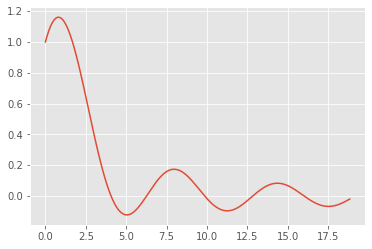

In [85]:
plt.plot(time_array.flatten(), strain_array.flatten(), label='strain')

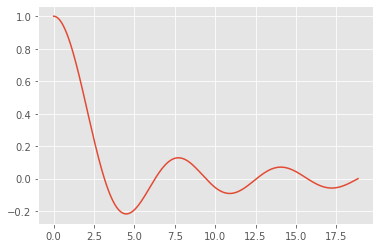

In [53]:
plt.plot(time_array.flatten(), stress_array.flatten(), label='stress')

## Data Treatment

In [54]:
# 'normalising'
time_sf = omega # we want T of effective curve to be 2pi. Teff = T*t_sf = 2pi*t_sf/omega = 2pi if t_sf = omega
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))

scaled_time_array = time_array*time_sf
if input_type == 'Strain':
    scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = stress_array*stress_sf
elif input_type == 'Stress':
    scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = strain_array*strain_sf

In [55]:
# add noise
noise_level = 0

noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

In [68]:
# sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_array.size)
reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = noisy_target_array[reordered_row_indices, :][:number_of_samples]

In [69]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

# Setup a custom library

In [70]:
from torch.autograd import grad

In [71]:
def stress_input_library(inputs, library_config):    
    
    prediction, data = inputs

    input_theta = library_config['input_theta'] # Recalls precalculated half of theta
    if data.shape[0] == 1: # Swaps real input_theta out for dummy in initialisation pass.
        input_theta = torch.ones((1, input_theta.shape[1]))
    
    # Use the result of the forward pass of the NN to calculate derivatives of prediction with respect to time. 
    output_derivs = library_deriv(data, prediction, library_config)
    output_theta = torch.cat((prediction, output_derivs), dim=1)
    
    strain_t = output_theta[:, 1:2] # Extract the first time derivative of strain
    strain = torch.cat((output_theta[:, 0:1], output_theta[:, 2:]), dim=1) # remove this before it gets put into theta
    strain *= -1
    theta = torch.cat((strain, input_theta), dim=1)
    
    return [strain_t], theta


def library_deriv(data, prediction, library_config):
    max_order = library_config['diff_order']
    
    # First derivative builds off prediction.
    derivs = grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
            
    return derivs

## Configuring DeepMoD

We precalculate half of the library in advance from the analytical expression used to define the stress manipulation profile. We then save this later in the config dictionary. First we also need to define a united maximum order of derivative to be calculated for the library, applied here, and to derivatives calculated during DeepMoD's execution.

In [72]:
diff_order = 3
input_data = scaled_input_torch_lambda(time_tensor)
input_derivs = library_deriv(time_tensor, input_data, {'diff_order': diff_order})
input_data, input_derivs = input_data.detach(), input_derivs.detach()
input_theta = torch.cat((input_data, input_derivs), dim=1)

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [73]:
## Running DeepMoD
config = {'n_in': 1, 'hidden_dims': [40, 40,40, 40, 40,40], 'n_out': 1, 'library_function': stress_input_library, 'library_args': {'library_config': {'diff_order': diff_order, 'input_theta': input_theta}}}

Now we instantiate the model. Note that the learning rate of the coefficient vector can typically be set up to an order of magnitude higher to speed up convergence without loss in accuracy

In [74]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}],betas=(0.99, 0.99))

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [75]:
train_deepmod(model, time_tensor, target_tensor, optimizer, 30001, {'l1': 1e-5})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      19200     64.00%               0s   3.16e-05   1.15e-06   1.03e-06   2.94e-05 

KeyboardInterrupt: 

Now that DeepMoD has converged, it has found the following numbers:

In [76]:
solution = model(time_tensor)[0].detach().numpy()

In [77]:
np.max(np.abs(strain_array),axis=0)

array([1.16023965])

In [78]:
print(model.fit.coeff_vector[0])

Parameter containing:
tensor([[ 3.8235e-01],
        [ 1.9967e-02],
        [-5.0344e-05],
        [ 6.6129e-01],
        [ 8.6929e-01],
        [-2.7174e-04],
        [ 2.7069e-06]], requires_grad=True)


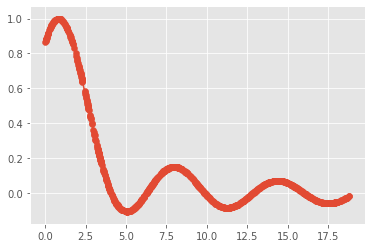

In [79]:
plt.scatter(time_tensor.detach().numpy().squeeze(), solution.flatten())
plt.plot(scaled_time_array.flatten(), scaled_target_array.flatten())